In [2]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score , hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns
import numpy as np
import pandas as pd



In [3]:
class MyDecisionTreeClassifier:
    def __init__(self):
        self.model = DecisionTreeClassifier()

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)
    
class MyLogisticClassifier:
    def __init__(self, num_classes=9, learning_rate=0.005, num_epochs=5000):
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.weights = None
        self.bias = None

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true):
        m = y_pred.shape[0]
        return -np.sum(np.log(y_pred) * y_true) / m

    def fit(self, X_train, y_train):
        m, n = X_train.shape
        self.weights = np.zeros((n, self.num_classes))
        self.bias = np.zeros((1, self.num_classes))

        for epoch in range(self.num_epochs):
            z = np.dot(X_train, self.weights) + self.bias
            y_pred = self.softmax(z)

            y_train_encoded = np.eye(self.num_classes)[y_train]  # One-hot encoding
            loss = self.cross_entropy_loss(y_pred, y_train_encoded)

            dz = y_pred - y_train_encoded
            dw = np.dot(X_train.T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(z)
        return np.argmax(y_pred, axis=1)

class MyMLPClassifier(object):
    def __init__(self, learning_rate=0.001,epochs = 5000, inputLayerSize: int = 12, hiddenLayerSize = [21] , outputLayerSize: int = 9):
        self.inputLayerSize = inputLayerSize
        self.outputLayerSize = outputLayerSize
        self.hiddenLayerSize = hiddenLayerSize
        self.activation = self.sigmoid
        self.activationPrime = self.sigmoidPrime
        self.learning_rate = learning_rate
        self.num_layers = len(hiddenLayerSize)+1
        self.weights = []
        self.weights.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize[0]))
        for i in range(1,self.num_layers-1):
            self.weights.append(np.random.randn(self.hiddenLayerSize[i-1], self.hiddenLayerSize[i]))
        self.weights.append(np.random.randn(self.hiddenLayerSize[-1], self.outputLayerSize))
        self.optimizer = 'SGD'
        self.max_iterations = epochs

    def forward(self, X):
        self.z = [None] * (len(self.weights))
        self.a = [None] * (len(self.weights)-1)
        
        self.z[0] = np.dot(X, self.weights[0])
        for i in range(0,len(self.a)):
            self.a[i] = self.activation(self.z[i])
            self.z[i+1] = np.dot(self.a[i],self.weights[i+1])
        yHat = self.softmax(self.z[-1])
        return yHat

    def relu(self, z):
        return np.maximum(0, z)  # ReLU activation

    def tanh(self, z):
        return np.tanh(z)  # Tanh activation

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoidPrime(self, z):
        return np.exp(-z) / ((1 + np.exp(-z))**2)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z))  # Subtracting max(z) for numerical stability
        return exp_z / exp_z.sum(axis=1, keepdims=True)

    def costFunction(self, X, y):
        self.yHat = self.forward(X)
        J = -np.sum(y * np.log(self.yHat)) / len(X)
        return J

    def costFunctionPrime(self, X, y):
        self.yHat = self.forward(X)
        deltas = [None] * (len(self.weights))
        deltas[-1] = self.yHat - y
        dJdWs = [None] * (len(self.weights))
        for i in range(len(deltas)-2,-1,-1):
            dJdWs[i+1] = np.dot(self.a[i].T, deltas[i+1])
            deltas[i] = np.dot(deltas[i+1],self.weights[i+1].T)*self.activationPrime(self.z[i])
        dJdWs[0] = np.dot(X.T, deltas[0])
        return dJdWs

    def reluPrime(self, z):
        return np.where(z > 0, 1, 0)  # Derivative of ReLU

    def tanhPrime(self, z):
        return 1 - np.tanh(z)**2  # Derivative of Tanh

    def backward(self, X, y, learning_rate):
        dJdWs = self.costFunctionPrime(X, y)
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * dJdWs[i]
    def fit(self, X, y, batch_size = 32, learning_rate=0.1, max_iterations=10000,wand = 0):
        if(self.optimizer == 'SGD'):
            return self.train_sgd(X=X, y=y,wand=wand)
        elif(self.optimizer == 'Batch'):
            return self.train_batch(X=X, y=y,wand=wand)
        elif(self.optimizer == 'MiniBatch'):
            return self.train_mini_batch(X=X, y=y,wand=wand)
    def train_sgd(self, X, y, learning_rate=0.1, max_iterations=10000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on MLP Classifier for WineQT Dataset")
        for i in range(self.max_iterations):
            idx = np.random.randint(len(X))
            self.backward(X[idx:idx+1], y[idx:idx+1], self.learning_rate)
            if i % 1 == 0:
                loss = self.costFunction(X, y)
                # print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")
    def train_batch(self, X, y, learning_rate=0.0001, max_iterations=10000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on MLP Classifier for WineQT Dataset")
        for i in range(self.max_iterations):
            self.backward(X, y, self.learning_rate)
            if i % 1 == 0:
                loss = self.costFunction(X, y)
                # print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")
    def train_mini_batch(self, X, y, batch_size=32, learning_rate=0.01, max_iterations=5000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on MLP Classifier for WineQT Dataset")
        for i in range(self.max_iterations):
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            for j in range(0, len(X), batch_size):
                batch_indices = indices[j:j+batch_size]
                self.backward(X[batch_indices], y[batch_indices], self.learning_rate)
            if i % 1 == 0:
                loss = self.costFunction(X, y)
                # print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")

    def predict(self, X):
        yHat = self.forward(X)
        # return yHat
        binary_predictions = np.zeros_like(yHat)
        binary_predictions[np.arange(len(yHat)), yHat.argmax(axis=1)] = 1
        return binary_predictions
        # return np.argmax(yHat, axis=1)
    def set_learning_rate(self, learning_rate):
        self.learning_rate = learning_rate

    def set_activation_function(self, activation_function):
        if(activation_function == 'sigmoid'):
            self.activation = self.sigmoid
            self.activationPrime = self.sigmoidPrime
        if(activation_function == 'relu'):
            self.activation = self.relu
            self.activationPrime = self.reluPrime
        if(activation_function == 'tanh'):
            self.activation = self.tanh
            self.activationPrime = self.tanhPrime

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def set_hidden_layers(self, hidden_layer_sizes):
        self.hiddenLayerSize = hidden_layer_sizes
        self.num_layers = len(self.hiddenLayerSize)+1
        self.weights = []
        self.weights.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize[0]))
        for i in range(1,self.num_layers-1):
            self.weights.append(np.random.randn(self.hiddenLayerSize[i-1], self.hiddenLayerSize[i]))
        self.weights.append(np.random.randn(self.hiddenLayerSize[-1], self.outputLayerSize))
        # self.W1 = np.random.randn(self.inputLayerSize, self.hiddenLayerSize)
        # self.W2 = np.random.randn(self.hiddenLayerSize, self.outputLayerSize)
        # self.weights, self.biases = self.initialize_weights()
    def set_epochs(self, epcohs):
        self.max_iterations = epochs
        print(self.max_iterations)


In [4]:
class MyDecisionTreeRegressor:
    def __init__(self):
        self.model = DecisionTreeRegressor()

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)
    
class MyLinearRegressor:
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        # X = X + np.eye(X.shape[0]) * 1e-16
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0
        X_transpose = X.T
        X = np.array(X)
        y = np.array(y)
        self.weights = np.dot(np.linalg.pinv(np.dot(X_transpose, X)), np.dot(X_transpose, y))
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return linear_model
    
class MyMLPRegressor(object):
    def __init__(self, learning_rate=0.001,epochs = 5000, inputLayerSize: int = 13, hiddenLayerSize = [13,13,13,13,13,13,13,13,13] , outputLayerSize: int = 1):
        self.inputLayerSize = inputLayerSize
        self.outputLayerSize = outputLayerSize
        self.hiddenLayerSize = hiddenLayerSize
        self.activation = self.sigmoid
        self.activationPrime = self.sigmoidPrime
        self.learning_rate = learning_rate
        # Weights (parameters)
        self.num_layers = len(hiddenLayerSize)+1
        self.weights = []
        self.weights.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize[0]))
        for i in range(1,self.num_layers-1):
            self.weights.append(np.random.randn(self.hiddenLayerSize[i-1], self.hiddenLayerSize[i]))
        self.weights.append(np.random.randn(self.hiddenLayerSize[-1], self.outputLayerSize))
        self.optimizer = 'MiniBatch'
        self.max_iterations = epochs

    def forward(self, X):
        self.z = [None] * (len(self.weights))
        self.a = [None] * (len(self.weights) - 1)

        self.z[0] = np.dot(X, self.weights[0])
        for i in range(0, len(self.a)):
            self.a[i] = self.activation(self.z[i])
            self.z[i + 1] = np.dot(self.a[i], self.weights[i + 1])
        yHat = self.z[-1]  # Linear activation for regression
        return yHat

    def relu(self, z):
        return np.maximum(0, z)  # ReLU activation

    def tanh(self, z):
        return np.tanh(z)  # Tanh activation

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoidPrime(self, z):
        return np.exp(-z) / ((1 + np.exp(-z))**2)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z))  # Subtracting max(z) for numerical stability
        return exp_z / exp_z.sum(axis=1, keepdims=True)

    def costFunction(self, X, y):
        self.yHat = self.forward(X)
        J = np.sum((y - self.yHat) ** 2) / (2 * len(X))  # Mean Squared Error
        return J

    def costFunctionPrime(self, X, y):
        self.yHat = self.forward(X)
        deltas = [None] * (len(self.weights))
        deltas[-1] = -(y - self.yHat)
        dJdWs = [None] * (len(self.weights))
        for i in range(len(deltas) - 2, -1, -1):
            dJdWs[i + 1] = np.dot(self.a[i].T, deltas[i + 1])
            deltas[i] = np.dot(deltas[i + 1], self.weights[i + 1].T) * self.activationPrime(self.z[i])
        dJdWs[0] = np.dot(X.T, deltas[0])
        return dJdWs

    def reluPrime(self, z):
        return np.where(z > 0, 1, 0)  # Derivative of ReLU

    def tanhPrime(self, z):
        return 1 - np.tanh(z)**2  # Derivative of Tanh

    def backward(self, X, y, learning_rate):
        dJdWs = self.costFunctionPrime(X, y)
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * dJdWs[i]
        # self.W1 -= learning_rate * dJdW1
        # self.W2 -= learning_rate * dJdW2
    def fit(self, X, y, batch_size = 32, learning_rate=0.1, max_iterations=10000,wand = 0):
        if(self.optimizer == 'SGD'):
            return self.train_sgd(X=X, y=y,wand=wand)
        elif(self.optimizer == 'Batch'):
            return self.train_batch(X=X, y=y,wand=wand)
        elif(self.optimizer == 'MiniBatch'):
            return self.train_mini_batch(X=X, y=y,wand=wand)
    def train_sgd(self, X, y, learning_rate=0.1, max_iterations=10000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on Housing Dataset in MLP Regression")
        for i in range(self.max_iterations):
            idx = np.random.randint(len(X))
            self.backward(X[idx:idx+1], y[idx:idx+1], self.learning_rate)
            if i % 100 == 0:
                loss = self.costFunction(X, y)
                print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")
    def train_batch(self, X, y, learning_rate=0.0001, max_iterations=10000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on Housing Dataset in MLP Regression")
        for i in range(self.max_iterations):
            self.backward(X, y, self.learning_rate)
            if i % 1 == 0:
                loss = self.costFunction(X, y)
                # print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")
    def train_mini_batch(self, X, y, batch_size=32, learning_rate=0.01, max_iterations=5000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on Housing Dataset in MLP Regression")
        for i in range(self.max_iterations):
            # Randomly shuffle the data and split into mini-batches
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            for j in range(0, len(X), batch_size):
                batch_indices = indices[j:j+batch_size]
                self.backward(X[batch_indices], y[batch_indices], self.learning_rate)
            if i % 1 == 0:
                loss = self.costFunction(X, y)
                # print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")

    def predict(self, X):
        yHat = self.forward(X)
        return yHat
    def set_learning_rate(self, learning_rate):
        self.learning_rate = learning_rate

    def set_activation_function(self, activation_function):
        if(activation_function == 'sigmoid'):
            self.activation = self.sigmoid
            self.activationPrime = self.sigmoidPrime
        if(activation_function == 'relu'):
            self.activation = self.relu
            self.activationPrime = self.reluPrime
        if(activation_function == 'tanh'):
            self.activation = self.tanh
            self.activationPrime = self.tanhPrime

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def set_hidden_layers(self, hidden_layer_sizes):
        self.hiddenLayerSize = hidden_layer_sizes
        self.num_layers = len(self.hiddenLayerSize)+1
        self.weights = []
        self.weights.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize[0]))
        for i in range(1,self.num_layers-1):
            self.weights.append(np.random.randn(self.hiddenLayerSize[i-1], self.hiddenLayerSize[i]))
        self.weights.append(np.random.randn(self.hiddenLayerSize[-1], self.outputLayerSize))
        # self.W1 = np.random.randn(self.inputLayerSize, self.hiddenLayerSize)
        # self.W2 = np.random.randn(self.hiddenLayerSize, self.outputLayerSize)
        # self.weights, self.biases = self.initialize_weights()
    def set_epochs(self, epcohs):
        self.max_iterations = epochs
        print(self.max_iterations)






In [5]:
data = pd.read_csv('HousingData.csv')
imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
data = data.fillna(data.mean())
X = data.drop(columns=['MEDV'])
y = data['MEDV']
# X = data.iloc[1:, :-1].reset_index(drop=True)
# y = data.iloc[1:, -1].reset_index(drop=True)

# scaler = StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)




In [6]:
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

X_train_std = std_scaler.fit_transform(X_train)
X_val_std = std_scaler.transform(X_val)
X_test_std = std_scaler.transform(X_test)

X_train_norm = minmax_scaler.fit_transform(X_train_std)
X_val_norm = minmax_scaler.transform(X_val_std)
X_test_norm = minmax_scaler.transform(X_test_std)
X_train = X_train_norm
X_val = X_val_norm
X_test = X_test_norm
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
print(X_train)
print(y_train)

[[5.18056442e-04 3.47368421e-01 3.65623822e-02 ... 6.17021277e-01
  9.91833629e-01 1.43487859e-01]
 [2.97300779e-04 2.63157895e-01 1.37580098e-01 ... 6.80851064e-01
  9.84123764e-01 1.59492274e-01]
 [1.74592552e-03 2.31578947e-01 1.75273276e-01 ... 6.91489362e-01
  9.43723054e-01 2.14955850e-01]
 ...
 [6.68786251e-05 8.42105263e-01 3.01545420e-02 ... 4.68085106e-01
  9.84884606e-01 1.17549669e-01]
 [1.25342233e-01 0.00000000e+00 6.36637769e-01 ... 8.08510638e-01
  2.72001014e-01 5.94370861e-01]
 [2.46945108e-03 0.00000000e+00 2.77044855e-01 ... 8.82978723e-01
  1.72964748e-01 2.45584989e-01]]
[36.1 22.9 24.5 25.  50.  34.9 31.7 24.1 22.1 14.1 42.8 19.3 32.2 26.4
 21.8 21.7  8.3 46.7 43.1 31.5 10.5 16.7 20.  33.3 17.8 50.  20.5 23.2
 13.1 19.6 22.8 28.7 30.7 22.9 21.9 23.9 32.7 24.3 21.5 24.6  8.5 26.4
 23.1 15.   8.8 19.3 23.9 24.7 19.8 23.8 13.3 29.  27.1 34.6 13.3 15.6
 12.5 14.6 11.  24.8 17.3  8.1 21.4 15.6 23.3 32.  38.7 30.1 20.5 32.5
 42.3 24.3 20.6 22.  18.2 15.   6.3 20.1 21.4

# Regression

In [24]:
def bagging_ensemble_regression(X_train, y_train,X_test,y_test, base0_estimator, base1_estimator, n0_estimators,stacking):
    ensemble_models = []
    y_preds = []
    y_tests = []
    if(stacking == "Blending"):
        X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y_train, test_size=0.3)
        sample_size = len(X_train)
        for _ in range(n0_estimators):
            sample_indices = np.random.choice(len(X_train), size=sample_size, replace=False)
            sample_X = X_train[sample_indices]
            sample_y = y_train[sample_indices]
            sample_y = np.array(sample_y)
            base_model = None
            if base0_estimator == "DecisionTree":
                base_model = MyDecisionTreeRegressor()
                base_model.fit(sample_X, sample_y)
            elif base0_estimator == "Linear":
                base_model = MyLinearRegressor()
                base_model.fit(sample_X, sample_y)
            elif base0_estimator == "MLP":
                base_model = MyMLPRegressor()
                y_train_array = np.array([[x] for x in sample_y])
                base_model.fit(sample_X, y_train_array)
            y_pred = base_model.predict(X_holdout)
            y_t = base_model.predict(X_test)
            y_tests.append(np.array(y_t))
            y_preds.append(np.array(y_pred))
            # print(y_preds)
            ensemble_models.append(base_model)
    elif stacking == "Stacking":
        sample_size = len(X_train)
        kf = KFold(n_splits=5)
        for i in range(n0_estimators):
            y_pred_fold = np.zeros(len(X_train))
            y_test_fold = np.zeros(len(X_test))

            for train_idx, val_idx in kf.split(X_train):
                X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
                y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

                base_model = None

                if base0_estimator == "DecisionTree":
                    base_model = MyDecisionTreeRegressor()
                    base_model.fit(X_train_fold, y_train_fold)
                elif base0_estimator == "Linear":
                    base_model = MyLinearRegressor()
                    base_model.fit(X_train_fold, y_train_fold)
                elif base0_estimator == "MLP":
                    base_model = MyMLPRegressor()
                    y_train_array = np.array([[x] for x in y_train_fold])
                    base_model.fit(X_train_fold, y_train_array)

                y_pred_fold[val_idx] = base_model.predict(X_val_fold).reshape(len(X_val_fold),)
            y_preds.append(y_pred_fold)
            y_tests.append(np.array(base_model.predict(X_test)))
            ensemble_models.append(base_model)
    def predict(X):
        # y_preds = np.array(y_preds)
        if(stacking == "Blending"):
            # print(np.array(y_preds))
            if(base1_estimator == "DecisionTree"):
                meta_model = MyDecisionTreeRegressor()
                # print(np.array(y_preds).reshape(2,91).shape)
                meta_model.fit(np.array(y_preds).reshape(n0_estimators,91).T, y_holdout)
                y_pred = meta_model.predict(np.array(y_tests).reshape(n0_estimators,102).T)
            elif(base1_estimator == "Linear"):
                meta_model = MyLinearRegressor()
                # print(np.array(y_preds).T)
                # print(np.array(y_tests).T)
                meta_model.fit(np.array(y_preds).reshape(n0_estimators,91).T, y_holdout)
                y_pred = meta_model.predict(np.array(y_tests).reshape(n0_estimators,102).T)
        elif(stacking == "Stacking"):
            if(base1_estimator == "DecisionTree"):
                meta_model = MyDecisionTreeRegressor()
                # print(np.array(y_tests).shape)
                meta_model.fit(np.array(y_preds).reshape(n0_estimators,303).T, y_train)
                y_pred = meta_model.predict(np.array(y_tests).reshape(n0_estimators,102).T)
            elif(base1_estimator == "Linear"):
                meta_model = MyLinearRegressor()
                meta_model.fit(np.array(y_preds).reshape(n0_estimators,303).T, y_train)
                y_pred = meta_model.predict(np.array(y_tests).reshape(n0_estimators,102).T)
        return y_pred
    return predict

bagged_regressor_decision_tree_soft = bagging_ensemble_regression(X_train, y_train,X_test,y_test, base0_estimator="DecisionTree",base1_estimator="Linear",n0_estimators=2, stacking = "Blending")
y_pred = bagged_regressor_decision_tree_soft(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 38.9522210610567


## Hyperparameter Tuning

In [249]:
n_estimators = [2]
level0_estimator = ["DecisionTree","Linear","MLP"]
level1_estimator = ["DecisionTree","Linear"]
stacking = ["Blending","Stacking"]
best_mse = 10000000
best_params = []
for i in n_estimators:
    for j in level0_estimator:
        for k in level1_estimator:
            for l in stacking:
                bagged_regressor = bagging_ensemble_regression(X_train, y_train,X_test,y_test, base0_estimator=j,base1_estimator=k,n0_estimators=i, stacking = l)
                y_pred = bagged_regressor(X_test)
                mse = mean_squared_error(y_test, y_pred)
                print("Mean Squared Error:", mse)
                print("n_estimators:",i)
                print("level0_estimator:",j)
                print("level1_estimator:",k)
                print("stacking:",l)
                print("-----------------------------------------------------")
                if(mse < best_mse):
                    best_mse = mse
                    best_params = [i,j,k,l]
print("Best MSE:",best_mse)
print("Best Parameters:",best_params)
                    

Mean Squared Error: 24.715901416121998
n_estimators: 2
level0_estimator: DecisionTree
level1_estimator: DecisionTree
stacking: Blending
-----------------------------------------------------
Mean Squared Error: 36.161025599128536
n_estimators: 2
level0_estimator: DecisionTree
level1_estimator: DecisionTree
stacking: Stacking
-----------------------------------------------------
Mean Squared Error: 19.969936823755273
n_estimators: 2
level0_estimator: DecisionTree
level1_estimator: Linear
stacking: Blending
-----------------------------------------------------
Mean Squared Error: 30.13433424347181
n_estimators: 2
level0_estimator: DecisionTree
level1_estimator: Linear
stacking: Stacking
-----------------------------------------------------
Mean Squared Error: 37.07784313725491
n_estimators: 2
level0_estimator: Linear
level1_estimator: DecisionTree
stacking: Blending
-----------------------------------------------------
Mean Squared Error: 39.056862745098044
n_estimators: 2
level0_estimato

## Heatmap

In [11]:
def plot_heatmap(base_estimator):
    n_estimators = [1, 2, 3]
    sample_fraction = [0.15, 0.25, 0.5, 0.75, 1]
    mse_values = np.zeros((len(n_estimators), len(sample_fraction)))

    for i, n_estimator in enumerate(n_estimators):
        for k, fraction in enumerate(sample_fraction):
            bagged_regressor = bagging_ensemble_regression(
                base_estimator=base_estimator,
                n_estimators=n_estimator,
                sample_fraction=fraction,
                with_replacement=True,  # You can adjust this as needed
                voting="soft"  # You can adjust the voting type as needed
            )
            y_pred = bagged_regressor(X_test)
            mse = mean_squared_error(y_test, y_pred)
            print("Mean Squared Error:", mse)
            print("n_estimators:",n_estimator)
            print("base_estimator:",base_estimator)
            print("sample_fraction:",fraction)
            print("-----------------------------------------------------")
            mse_values[i, k] = mse

    # Create a heatmap of MSE values
    plt.figure(figsize=(12, 8))
    sns.heatmap(mse_values, annot=True, xticklabels=sample_fraction, yticklabels=n_estimators)
    plt.xlabel("Fraction of Samples")
    plt.ylabel("Number of Estimators")
    plt.title("Mean Squared Error Heatmap for Different Hyperparameters")
    plt.show()

Mean Squared Error: 39.24774509803922
n_estimators: 1
base_estimator: DecisionTree
sample_fraction: 0.15
-----------------------------------------------------
Mean Squared Error: 37.54529411764706
n_estimators: 1
base_estimator: DecisionTree
sample_fraction: 0.25
-----------------------------------------------------
Mean Squared Error: 16.267549019607845
n_estimators: 1
base_estimator: DecisionTree
sample_fraction: 0.5
-----------------------------------------------------
Mean Squared Error: 21.59519607843138
n_estimators: 1
base_estimator: DecisionTree
sample_fraction: 0.75
-----------------------------------------------------
Mean Squared Error: 21.500294117647062
n_estimators: 1
base_estimator: DecisionTree
sample_fraction: 1
-----------------------------------------------------
Mean Squared Error: 24.59822869099591
n_estimators: 2
base_estimator: DecisionTree
sample_fraction: 0.15
-----------------------------------------------------
Mean Squared Error: 25.908711141471393
n_estimat

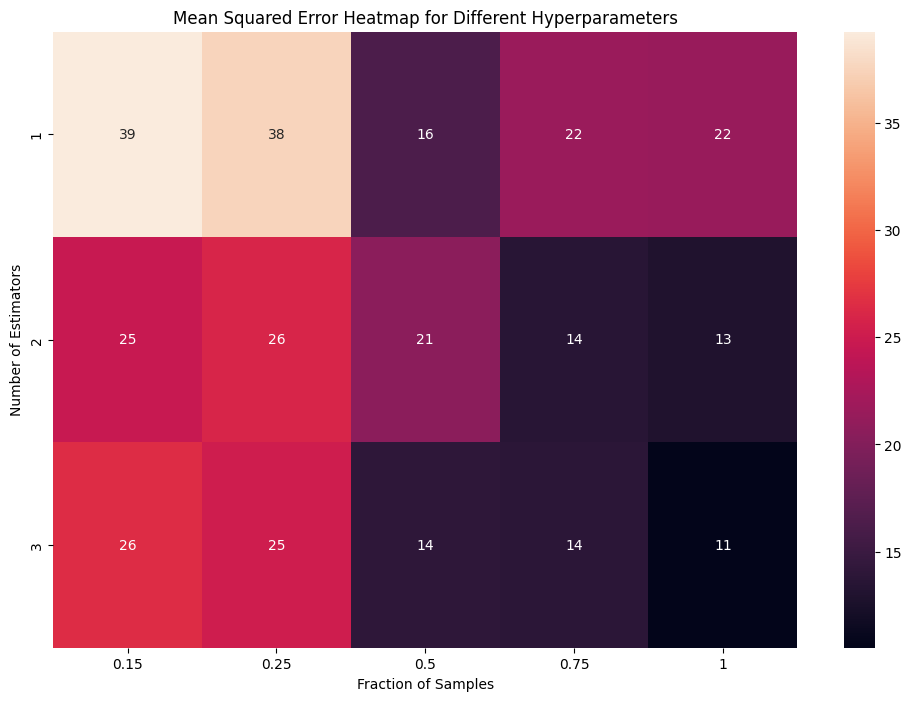

In [12]:
plot_heatmap(base_estimator = "DecisionTree")

In [250]:
data = pd.read_csv('WineQT.csv', header=0)
train_data, test_data = train_test_split(data, test_size=0.2,random_state = 42)

scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

imputer = SimpleImputer(strategy='mean')  

train_data_scaled = scaler.fit_transform(imputer.fit_transform(train_data.drop(columns=['quality'])))
train_labels = train_data['quality']

test_data_scaled = scaler.transform(imputer.transform(test_data.drop(columns=['quality'])))

train_data_scaled_normalized = minmax_scaler.fit_transform(train_data_scaled)
test_data_scaled_normalized = minmax_scaler.transform(test_data_scaled)

X_train = train_data_scaled
y_train = train_labels
X_test = test_data_scaled
y_test = test_data['quality']
y_train = np.array(y_train)
y_test = np.array(y_test)
# y_train = pd.get_dummies(y_train).astype(int)
# y_train = np.eye(9)[y_train]
# y_train = np.array(y_train)
# y_test = pd.get_dummies(y_test).astype(int)
# print(X_train)
# print(y_train)
# y_test = np.eye(9)[y_test]
# y_test = np.array(y_test)
y_test = np.eye(9)[y_test]
y_test = np.array(y_test)


# Classification

In [253]:
def bagging_ensemble_classification(X_train, y_train, X_test, y_test, base0_classifier, base1_classifier, n0_estimators, stacking):
    ensemble_models = []
    y_preds = []
    y_tests = []
    if(stacking == "Blending"):
        X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y_train, test_size=0.2)
        sample_size = len(X_train)
        for _ in range(n0_estimators):
            sample_indices = np.random.choice(len(X_train), size=sample_size, replace=False)
            sample_X = X_train[sample_indices]  # Assuming X_train is a DataFrame
            sample_y = y_train[sample_indices]  # Assuming y_train is a Series
            base_model = None
            if base0_classifier == "DecisionTree":
                base_model = MyDecisionTreeClassifier()
                sample_y = np.eye(9)[sample_y]
                sample_y = np.array(sample_y)
                # print(sample_X.shape)
                base_model.fit(sample_X, sample_y)
            elif base0_classifier == "Logistic":
                base_model = MyLogisticClassifier()
                base_model.fit(sample_X, sample_y)
            elif base0_classifier == "MLP":
                base_model = MyMLPClassifier()
                sample_y = np.eye(9)[sample_y]
                sample_y = np.array(sample_y)
                base_model.fit(sample_X, sample_y)
            if(base0_classifier == "MLP" or base0_classifier == "DecisionTree"):
                y_pred = base_model.predict(X_holdout)
                y_pred = np.argmax(y_pred, axis=1)
                y_t = base_model.predict(X_test)
                y_t = np.argmax(y_t, axis=1)
                y_tests.append(np.array(y_t))
                y_preds.append(np.array(y_pred))
            elif(base0_classifier == "Logistic"):
                y_pred = base_model.predict(X_holdout)
                y_t = base_model.predict(X_test)
                y_tests.append(np.array(y_t))
                y_preds.append(np.array(y_pred))
            ensemble_models.append(base_model)
    elif stacking == "Stacking":
        n_splits = 5  
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        for i in range(n0_estimators):
            y_pred_fold = np.zeros(len(X_train))
            y_test_fold = np.zeros(len(X_test))

            for train_idx, val_idx in skf.split(X_train, y_train):
                X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
                y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

                base_model = None

                if base0_classifier == "DecisionTree":
                    base_model = MyDecisionTreeClassifier()
                    y_train_fold = np.eye(9)[y_train_fold]
                    y_train_fold = np.array(y_train_fold)
                    base_model.fit(X_train_fold, y_train_fold)
                elif base0_classifier == "Logistic":
                    base_model = MyLogisticClassifier()
                    base_model.fit(X_train_fold, y_train_fold)
                elif base0_classifier == "MLP":
                    base_model = MyMLPClassifier()
                    y_train_fold = np.eye(9)[y_train_fold]
                    y_train_fold = np.array(y_train_fold)
                    base_model.fit(X_train_fold, y_train_fold)
                if(base0_classifier != "Logistic"):
                    y_pred_fold[val_idx] = base_model.predict(X_val_fold).argmax(axis=1)
            if(base0_classifier == "MLP" or base0_classifier == "DecisionTree"):
                # y_pred_fold = np.argmax(y_pred_fold, axis=1)
                y_preds.append(np.array(y_pred_fold))
                y_t = base_model.predict(X_test)
                y_t = np.argmax(y_t, axis=1)
                y_tests.append(np.array(y_t))
            elif(base0_classifier == "Logistic"):
                y_preds.append(np.array(y_pred_fold))
                y_t = base_model.predict(X_test)
                y_tests.append(np.array(y_t))
            ensemble_models.append(base_model)
    def predict(X):
        # print(np.array(y_preds).shape)
        y_preds_copy = np.array(y_preds)
        y_tests_copy = np.array(y_tests)
        # print(y_preds_copy.shape)
        # print(y_tests_copy.shape)
        if(stacking == "Blending"):
            if(base1_classifier == "DecisionTree"):
                meta_model = MyDecisionTreeClassifier()
                y_holdout1 = np.eye(9)[y_holdout]
                y_holdout1 = np.array(y_holdout1)
                # print(y_holdout1.shape)
                meta_model.fit(np.array(y_preds_copy).reshape(n0_estimators, 183).T, y_holdout1)
                y_pred = meta_model.predict(np.array(y_tests_copy).reshape(n0_estimators, 229).T)
            elif(base1_classifier == "Logistic"):
                meta_model = MyLogisticClassifier()
                meta_model.fit(np.array(y_preds_copy).reshape(n0_estimators, 183).T, y_holdout)
                y_pred = meta_model.predict(np.array(y_tests_copy).reshape(n0_estimators, 229).T)
                y_pred_copy = y_pred.copy()
                y_pred = np.zeros((229,9))
                for i in range(0,229):
                    y_pred[i][y_pred_copy[i]] = 1
        elif(stacking == "Stacking"):
            if(base1_classifier == "DecisionTree"):
                meta_model = MyDecisionTreeClassifier()
                meta_model.fit(np.array(y_preds_copy).reshape(n0_estimators, 914).T, y_train)
                y_pred = meta_model.predict(np.array(y_tests_copy).reshape(n0_estimators, 229).T)
                y_pred_copy = y_pred.copy()
                y_pred = np.zeros((229,9))
                for i in range(0,229):
                    y_pred[i][y_pred_copy[i]] = 1
            elif(base1_classifier == "Logistic"):
                meta_model = MyLogisticClassifier()
                meta_model.fit(np.array(y_preds_copy).reshape(n0_estimators, 914).T, y_train)
                y_pred = meta_model.predict(np.array(y_tests_copy).reshape(n0_estimators, 229).T)
                y_pred_copy = y_pred.copy()
                y_pred = np.zeros((229,9))
                for i in range(0,229):
                    y_pred[i][y_pred_copy[i]] = 1
        return y_pred
    return predict
# Example usage for bagging ensemble with Decision Tree classifier and soft voting
bagged_classifier_decision_tree_soft = bagging_ensemble_classification(X_train, y_train, X_test, y_test, base0_classifier="DecisionTree", base1_classifier="Logistic", n0_estimators=5, stacking="Stacking")
y_pred = bagged_classifier_decision_tree_soft(X_test)
y_pred = np.array(y_pred)
y_test = np.array(y_test)
print(y_pred[0])
print(y_test[0])
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]
Accuracy: 0.5240174672489083


## Hyperparameter Tuning & Comparison

In [254]:
n_estimators = [2]
level0_estimator = ["DecisionTree","Logistic","MLP"]
level1_estimator = ["DecisionTree","Logistic"]
stacking = ["Blending","Stacking"]
best_accuracy = 0
best_params = []
for i in n_estimators:
    for j in level0_estimator:
        for k in level1_estimator:
            for l in stacking:
                    bagged_classifier = bagging_ensemble_classification(X_train, y_train, X_test, y_test, base0_classifier=j, base1_classifier=k, n0_estimators=i, stacking=l)
                    y_pred = bagged_classifier(X_test)
                    y_pred = np.array(y_pred)
                    y_test = np.array(y_test)
                    acc = accuracy_score(y_test, y_pred)
                    print("Accuracy:", acc)
                    print("n_estimators:",i)
                    print("level0_classifier:",j)
                    print("level1_classifier:",k)
                    print("stacking:",l)
                    print("-----------------------------------------------------")
                    if(acc >= best_accuracy):
                        best_accuracy = acc
                        best_params = [i,j,k,l]
print("Best Accuracy:",best_accuracy)
print("Best Parameters:",best_params)
                    

Accuracy: 0.4978165938864629
n_estimators: 2
level0_classifier: DecisionTree
level1_classifier: DecisionTree
stacking: Blending
-----------------------------------------------------
Accuracy: 0.5633187772925764
n_estimators: 2
level0_classifier: DecisionTree
level1_classifier: DecisionTree
stacking: Stacking
-----------------------------------------------------
Accuracy: 0.43231441048034935
n_estimators: 2
level0_classifier: DecisionTree
level1_classifier: Logistic
stacking: Blending
-----------------------------------------------------
Accuracy: 0.5502183406113537
n_estimators: 2
level0_classifier: DecisionTree
level1_classifier: Logistic
stacking: Stacking
-----------------------------------------------------
Accuracy: 0.37117903930131
n_estimators: 2
level0_classifier: Logistic
level1_classifier: DecisionTree
stacking: Blending
-----------------------------------------------------
Accuracy: 0.4192139737991266
n_estimators: 2
level0_classifier: Logistic
level1_classifier: DecisionTre

## Heatmap

In [53]:
def plot_heatmap(base_classifier):
    n_estimators = [1, 2, 3]
    sample_fraction = [0.15, 0.25, 0.5, 0.75, 1]
    acc_values = np.zeros((len(n_estimators), len(sample_fraction)))

    for i, n_estimator in enumerate(n_estimators):
        for k, fraction in enumerate(sample_fraction):
            bagged_classifier = bagging_ensemble_classification(
                base_classifier=base_classifier,
                n_estimators=n_estimator,
                sample_fraction=fraction,
                with_replacement=True, 
                voting="soft"  
            )
            y_pred = bagged_classifier(X_test)
            acc = accuracy_score(y_test, y_pred)
            print("Accuracy:", acc)
            print("n_estimators:",n_estimator)
            print("base_classifier:",base_classifier)
            print("sample_fraction:",fraction)
            print("-----------------------------------------------------")
            acc_values[i, k] = acc

    # Create a heatmap of MSE values
    plt.figure(figsize=(12, 8))
    sns.heatmap(acc_values, annot=True, xticklabels=sample_fraction, yticklabels=n_estimators)
    plt.xlabel("Fraction of Samples")
    plt.ylabel("Number of Estimators")
    plt.title("Accuracy Heatmap for Different Hyperparameters")
    plt.show()

Accuracy: 0.48034934497816595
n_estimators: 1
base_classifier: DecisionTree
sample_fraction: 0.15
-----------------------------------------------------
Accuracy: 0.4978165938864629
n_estimators: 1
base_classifier: DecisionTree
sample_fraction: 0.25
-----------------------------------------------------
Accuracy: 0.5938864628820961
n_estimators: 1
base_classifier: DecisionTree
sample_fraction: 0.5
-----------------------------------------------------
Accuracy: 0.5764192139737991
n_estimators: 1
base_classifier: DecisionTree
sample_fraction: 0.75
-----------------------------------------------------
Accuracy: 0.5240174672489083
n_estimators: 1
base_classifier: DecisionTree
sample_fraction: 1
-----------------------------------------------------
Accuracy: 0.4497816593886463
n_estimators: 2
base_classifier: DecisionTree
sample_fraction: 0.15
-----------------------------------------------------
Accuracy: 0.5065502183406113
n_estimators: 2
base_classifier: DecisionTree
sample_fraction: 0.25


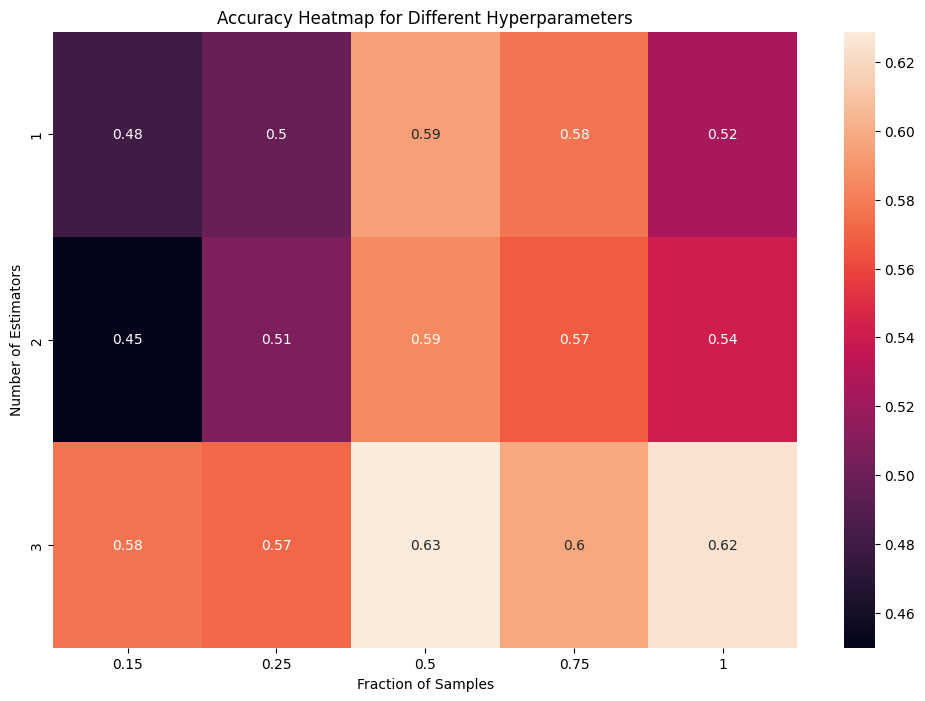

In [54]:
plot_heatmap(base_classifier = "DecisionTree")